# Digital Musicology (DH-401)
## Assignment 2: Pitch and keys
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

In [1]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn

## 0. Dataset preparation

In [2]:
%%time

# Suppress SettingWithCopy warnings
pd.options.mode.chained_assignment = None

keys_dataset = pd.read_csv('DM2022 - Assignment 2 [Dataset].csv', converters = {'duration': fractions.Fraction, 'nominal_duration': fractions.Fraction, 'scalar': fractions.Fraction}, index_col = 0, low_memory = False)
# Convert strings to bool
string_to_bool = {'True': True, 'False': False}
keys_dataset['globalkey_is_minor'].map(string_to_bool)
keys_dataset['localkey_is_minor'].map(string_to_bool)

# Function to convert from cpc fifths ordering to semitones ordering
fifths_to_semitones = lambda x: x+6 if(x%2==1 and x<6) else(x-6 if(x%2==1 and x>6) else x)

# Convert to chromatic pitch-class (fifths and semitones ordering)
keys_dataset['cpc_f'] = keys_dataset['tpc'].mod(12)
keys_dataset['cpc_s'] = keys_dataset['midi'].mod(12)

# Get only labeled dataset
labeled_df = keys_dataset[keys_dataset['globalkey_is_minor'].notna()]

labeled_df['globalkey_cpc_f'] = labeled_df['globalkey_tpc'].mod(12)
labeled_df['globalkey_cpc_s'] = labeled_df['globalkey_cpc_f'].apply(fifths_to_semitones)

labeled_df['localkey_tpc'] = labeled_df['localkey_relativetpc'] + labeled_df['globalkey_tpc']
labeled_df['localkey_cpc_f'] = labeled_df['localkey_tpc'].mod(12)
labeled_df['localkey_cpc_s'] = labeled_df['localkey_cpc_f'].apply(fifths_to_semitones)

# Transpose all pieces to tonic reference (with the Ground Truth)
labeled_df['cpc_f_trsp_tonic'] = (labeled_df['cpc_f'] - labeled_df['globalkey_cpc_f']).mod(12)
labeled_df['cpc_s_trsp_tonic'] = (labeled_df['cpc_s'] - labeled_df['globalkey_cpc_s']).mod(12)

# Create useful representation of localkey groundtruth
pitch_classes_semitones = ['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B']
labeled_df['localkey_groundtruth'] = labeled_df.localkey_cpc_s.apply(lambda x: pitch_classes_semitones[int(x)]) + labeled_df.localkey_is_minor.apply(lambda x: 'minor' if x else "Major")

labeled_df

CPU times: user 8.47 s, sys: 813 ms, total: 9.28 s
Wall time: 9.89 s


,n,piece,mn,mn_onset,timesig,act_dur,staff,voice,duration,gracenote,...,cpc_f,cpc_s,globalkey_cpc_f,globalkey_cpc_s,localkey_tpc,localkey_cpc_f,localkey_cpc_s,cpc_f_trsp_tonic,cpc_s_trsp_tonic,localkey_groundtruth
0,0,MozartSonatas/K280-1,1,0,3/4,3/4,2,1,1/4,NaN,...,11,5,11.0,5.0,-1.0,11.0,5.0,0.0,0.0,FMajor
1,1,MozartSonatas/K280-1,1,0,3/4,3/4,2,1,1/4,NaN,...,11,5,11.0,5.0,-1.0,11.0,5.0,0.0,0.0,FMajor
2,2,MozartSonatas/K280-1,1,0,3/4,3/4,1,1,1/4,NaN,...,0,0,11.0,5.0,-1.0,11.0,5.0,1.0,7.0,FMajor
3,3,MozartSonatas/K280-1,1,0,3/4,3/4,1,1,1/4,NaN,...,11,5,11.0,5.0,-1.0,11.0,5.0,0.0,0.0,FMajor
4,4,MozartSonatas/K280-1,1,0,3/4,3/4,1,1,1/4,NaN,...,3,9,11.0,5.0,-1.0,11.0,5.0,4.0,4.0,FMajor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404338,643,CorelliTrioSonatas/op04n04d,31,3/4,12/8,11/8,2,1,3/8,NaN,...,2,2,2.0,2.0,2.0,2.0,2.0,0.0,0.0,DMajor
404339,644,CorelliTrioSonatas/op04n04d,31,3/4,12/8,11/8,1,1,3/8,NaN,...,6,6,2.0,2.0,2.0,2.0,2.0,4.0,4.0,DMajor
404340,645,CorelliTrioSonatas/op04n04d,31,9/8,12/8,11/8,3,1,1/4,NaN,...,2,2,2.0,2.0,2.0,2.0,2.0,0.0,0.0,DMajor
404341,646,CorelliTrioSonatas/op04n04d,31,9/8,12/8,11/8,2,1,1/4,NaN,...,2,2,2.0,2.0,2.0,2.0,2.0,0.0,0.0,DMajor


In [3]:
major_df = labeled_df[labeled_df['globalkey_is_minor'] == False]
major_df[['piece','globalkey','globalkey_tpc','globalkey_cpc_f','globalkey_cpc_s','tpc','cpc_f','cpc_s','cpc_f_trsp_tonic','cpc_s_trsp_tonic']]

,piece,globalkey,globalkey_tpc,globalkey_cpc_f,globalkey_cpc_s,tpc,cpc_f,cpc_s,cpc_f_trsp_tonic,cpc_s_trsp_tonic
0,MozartSonatas/K280-1,F,-1.0,11.0,5.0,-1,11,5,0.0,0.0
1,MozartSonatas/K280-1,F,-1.0,11.0,5.0,-1,11,5,0.0,0.0
2,MozartSonatas/K280-1,F,-1.0,11.0,5.0,0,0,0,1.0,7.0
3,MozartSonatas/K280-1,F,-1.0,11.0,5.0,-1,11,5,0.0,0.0
4,MozartSonatas/K280-1,F,-1.0,11.0,5.0,3,3,9,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...
404338,CorelliTrioSonatas/op04n04d,D,2.0,2.0,2.0,2,2,2,0.0,0.0
404339,CorelliTrioSonatas/op04n04d,D,2.0,2.0,2.0,6,6,6,4.0,4.0
404340,CorelliTrioSonatas/op04n04d,D,2.0,2.0,2.0,2,2,2,0.0,0.0
404341,CorelliTrioSonatas/op04n04d,D,2.0,2.0,2.0,2,2,2,0.0,0.0


In [4]:
minor_df = labeled_df[labeled_df['globalkey_is_minor'] == True]
minor_df[['piece','globalkey','globalkey_tpc','globalkey_cpc_f','globalkey_cpc_s','tpc','cpc_f','cpc_s','cpc_f_trsp_tonic','cpc_s_trsp_tonic']]

,piece,globalkey,globalkey_tpc,globalkey_cpc_f,globalkey_cpc_s,tpc,cpc_f,cpc_s,cpc_f_trsp_tonic,cpc_s_trsp_tonic
6256,MozartSonatas/K310-1,a,3.0,3.0,9.0,9,9,3,6.0,6.0
6257,MozartSonatas/K310-1,a,3.0,3.0,9.0,3,3,9,0.0,0.0
6258,MozartSonatas/K310-1,a,3.0,3.0,9.0,0,0,0,9.0,3.0
6259,MozartSonatas/K310-1,a,3.0,3.0,9.0,4,4,4,1.0,7.0
6260,MozartSonatas/K310-1,a,3.0,3.0,9.0,4,4,4,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...
403690,CorelliTrioSonatas/op03n07a_reviewed,e,4.0,4.0,4.0,9,9,3,5.0,11.0
403691,CorelliTrioSonatas/op03n07a_reviewed,e,4.0,4.0,4.0,4,4,4,0.0,0.0
403692,CorelliTrioSonatas/op03n07a_reviewed,e,4.0,4.0,4.0,4,4,4,0.0,0.0
403693,CorelliTrioSonatas/op03n07a_reviewed,e,4.0,4.0,4.0,4,4,4,0.0,0.0


## I. Constructing Major and minor protoypes through data

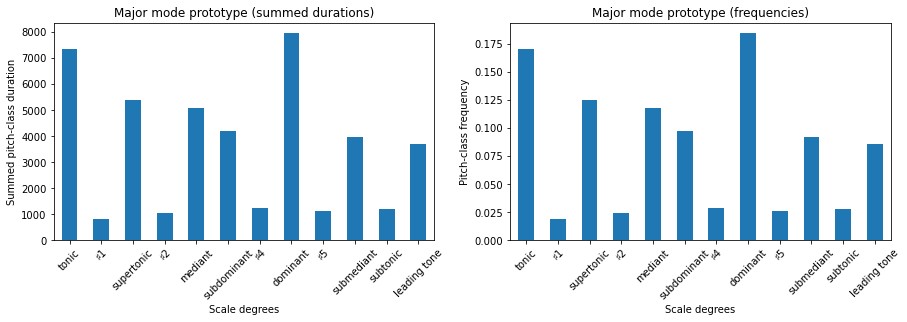

In [39]:
def get_major_prototype(major_df, subset, plot=False):
    grouped_major_df = major_df[major_df.piece.isin(subset)].groupby('cpc_s_trsp_tonic').duration.sum().apply(float)
    L1_norm = grouped_major_df.sum()
    major_vec = grouped_major_df.div(L1_norm).to_numpy()
    
    if plot:
        scale_degrees = ['tonic','♯1','supertonic','♯2','mediant','subdominant','♯4','dominant','♯5','submediant','subtonic','leading tone']
        
        fig, ax = plt.subplots(ncols=2, figsize=(15,4))
        
        grouped_major_df.plot(ax=ax[0],kind = 'bar')
        ax[0].set_xticklabels(scale_degrees,rotation=45)
        ax[0].set_title("Major mode prototype (summed durations)")
        ax[0].set_xlabel('Scale degrees')
        ax[0].set_ylabel('Summed pitch-class duration')
        

        grouped_major_df.div(L1_norm).plot(ax=ax[1],kind = 'bar')
        ax[1].set_xticklabels(scale_degrees,rotation=45)
        ax[1].set_title("Major mode prototype (frequencies)")
        ax[1].set_xlabel('Scale degrees')
        ax[1].set_ylabel('Pitch-class frequency')
       
    
    return major_vec

get_major_prototype(major_df, subset=major_df.piece.unique(), plot=True);

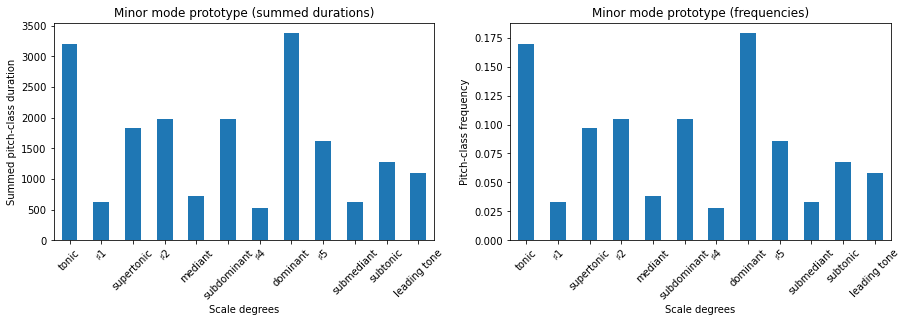

In [42]:
def get_minor_prototype(minor_df, subset, plot=False):
    grouped_minor_df = minor_df[minor_df.piece.isin(subset)].groupby('cpc_s_trsp_tonic').duration.sum().apply(float)
    L1_norm = grouped_minor_df.sum()
    minor_vec = grouped_minor_df.div(L1_norm).to_numpy()
        
    if plot:
        scale_degrees = ['tonic','♯1','supertonic','♯2','mediant','subdominant','♯4','dominant','♯5','submediant','subtonic','leading tone']

        fig, ax = plt.subplots(ncols=2, figsize=(15,4))
        
        grouped_minor_df.plot(ax=ax[0],kind = 'bar')
        ax[0].set_xticklabels( scale_degrees, rotation=45)
        ax[0].set_xlabel('Scale degrees')
        ax[0].set_ylabel('Summed pitch-class duration')
        ax[0].set_title('Minor mode prototype (summed durations)')
        

        
        grouped_minor_df.div(L1_norm).plot(ax=ax[1],kind = 'bar')
        ax[1].set_xticklabels( scale_degrees, rotation=45)
        ax[1].set_xlabel('Scale degrees')
        ax[1].set_ylabel('Pitch-class frequency')
        ax[1].set_title('Minor mode prototype (frequencies)')
        
    
    return minor_vec

get_minor_prototype(minor_df, subset=minor_df.piece.unique(), plot=True);

## II. Global key inference

In [7]:
def globalkey_classifier(piece, major_vec, minor_vec, plot=False):
    piece_df = keys_dataset[(keys_dataset['piece'] == piece)]
    dists = np.empty([12,2])
    
    for i_s_transpose in range(12):
        grouped_df = piece_df.groupby('cpc_s').duration.sum().apply(float)
        grouped_df = grouped_df.reindex(range(12), fill_value=0) #need to reindex as some pitch-classes never occur in some pieces
        L1_norm = grouped_df.sum()
        piece_vec = grouped_df.div(L1_norm).to_numpy()
        
        major_vec_shifted = np.roll(major_vec, i_s_transpose)
        minor_vec_shifted = np.roll(minor_vec, i_s_transpose)
        dists[i_s_transpose, 0] = np.linalg.norm(major_vec_shifted - piece_vec, 2)
        dists[i_s_transpose, 1] = np.linalg.norm(minor_vec_shifted - piece_vec, 2)

    key_idx = np.unravel_index(dists.argmin(), dists.shape)
    
    pitch_classes_semitones = ['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B']
    modes = ['Major', 'minor']
    
    pred_globalkey = (pitch_classes_semitones[key_idx[0]], modes[key_idx[1]])
    
    if plot:
        grouped_df.div(L1_norm).plot(kind = 'bar')
        plt.xticks(range(len(pitch_classes_semitones)), pitch_classes_semitones, rotation='horizontal')
        plt.xlabel('Pitch-class')
        plt.ylabel('Frequency')
        plt.title(f'Pitch-class frequencies for "{piece}"')
        plt.show()
    
    return pred_globalkey

def globalkey_groundtruth(piece):
    piece_df = labeled_df[(labeled_df['piece'] == piece)]
    
    pitch_classes_semitones = ['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B']

    tonic = pitch_classes_semitones[int(piece_df.globalkey_cpc_s.unique()[0])]
    mode = "minor" if piece_df.globalkey_is_minor.unique()[0] else "Major"
    
    groundtruth_key = (tonic, mode)
    
    return groundtruth_key

### a. Global key of a random piece

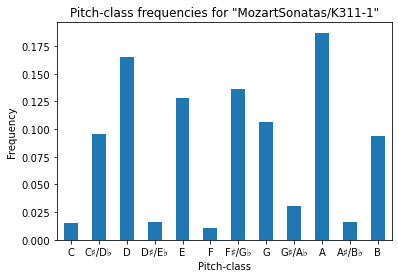

Piece: MozartSonatas/K311-1
Prediction: D Major
Ground truth: D Major


In [8]:
# Get major and minor prototypes based on all labeled data
major_vec = get_major_prototype(major_df, subset=major_df.piece.unique());
minor_vec = get_minor_prototype(minor_df, subset=minor_df.piece.unique());

# Predict key of random piece
random_piece = labeled_df['piece'].sample(n=1).item()
pred_globalkey = globalkey_classifier(random_piece, major_vec, minor_vec, plot=True)
groundtruth_key = globalkey_groundtruth(random_piece)

print(f'Piece: {random_piece}')
print(f'Prediction: {pred_globalkey[0]} {pred_globalkey[1]}')
print(f'Ground truth: {groundtruth_key[0]} {groundtruth_key[1]}')

### b. Global key classification pipeline

In [9]:
%%time

X = [] # features: piece name
y = [] # labels: tonic/mode pair
for piece in labeled_df.piece.unique():
    X.append(piece)
    y.append(globalkey_groundtruth(piece))

CPU times: user 6.12 s, sys: 85.2 ms, total: 6.21 s
Wall time: 6.46 s


In [ ]:
%%time

accuracies=[]
for fold in range(30):
    # Split training and testing data
    X_train, X_test, _, y_test = train_test_split(X, y, test_size=0.30, random_state=None)

    # Create training model
    major_vec = get_major_prototype(major_df, subset=X_train)
    minor_vec = get_minor_prototype(minor_df, subset=X_train)

    y_test_globalkey = []
    y_pred_globalkey = []
    i = 0
    for piece in X_test:
        pred_globalkey = globalkey_classifier(piece, major_vec, minor_vec)
        y_test_globalkey.append(y_test[i][0]+y_test[i][1])
        y_pred_globalkey.append(pred_globalkey[0]+pred_globalkey[1])
        i = i+1
        
    accuracies.append(metrics.accuracy_score(y_test_globalkey, y_pred_globalkey))

### c. Global key model evaluation

In [ ]:
print(f'Accuracy Mean: {np.mean(accuracies)}\n')
print(f'Accuracy Variance: {np.var(accuracies)}\n')

# Plot histogram/density of runs with mean and standard deviation
seaborn.histplot(accuracies, kde=True, stat='density', bins=8)
plt.axvline(np.mean(accuracies), c='r', ls='-', lw=2)
plt.axvline(np.mean(accuracies)-np.std(accuracies), c='b', ls='--', lw=2)
plt.axvline(np.mean(accuracies)+np.std(accuracies), c='b', ls='--', lw=2)
plt.xlabel('Model accuracy')
plt.show()
#seaborn.violinplot(accuracies)

### III. Local key modulation inference

In [ ]:
# Local key modulations

cols = ['piece','localkey']
unique_modulations_df = labeled_df[cols].loc[(labeled_df[cols].shift() != labeled_df[cols]).any(axis=1)]
count_modulations_df = unique_modulations_df.groupby('piece').count()

print(f'"{count_modulations_df.idxmax().item()}" has the largest number of modulations: {count_modulations_df.max().item()}')

In [ ]:
def localkey_classifier(piece, major_vec, minor_vec, window_size_in_bars):
    piece_df = keys_dataset[(keys_dataset['piece'] == piece)]
    
    piece_df.insert(3, 'windownum', (np.maximum((piece_df['mn'] - 1),0)//window_size_in_bars + 1))
    
    num_windows = piece_df.windownum.max()
    
    # Run key classifier for each window
    for windownum in range(1, num_windows+1):
        piece_df_window = piece_df[(piece_df['windownum'] == windownum)]
        
        dists = np.empty([12,2])
        
        for i_s_transpose in range(12):
            grouped_df = piece_df_window.groupby('cpc_s').duration.sum().apply(float)
            grouped_df = grouped_df.reindex(range(12), fill_value=0) #need to reindex as some pitch-classes never occur in some pieces
            L1_norm = grouped_df.sum()
            piece_vec = grouped_df.div(L1_norm).to_numpy() if L1_norm else grouped_df.to_numpy()

            major_vec_shifted = np.roll(major_vec, i_s_transpose)
            minor_vec_shifted = np.roll(minor_vec, i_s_transpose)
            dists[i_s_transpose, 0] = np.linalg.norm(major_vec_shifted - piece_vec, 2)
            dists[i_s_transpose, 1] = np.linalg.norm(minor_vec_shifted - piece_vec, 2)
        
        key_idx = np.unravel_index(dists.argmin(), dists.shape)

        pitch_classes_semitones = ['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B']
        modes = ['Major', 'minor']
        
        # Map predicted key to each window
        piece_df.loc[(piece_df.windownum==windownum), 'localkey_tonic_pred'] = pitch_classes_semitones[key_idx[0]]
        piece_df.loc[(piece_df.windownum==windownum), 'localkey_mode_pred'] = modes[key_idx[1]]
    
    # Return 2D array of predicted keys per onset
    localkey_tonic_preds = piece_df['localkey_tonic_pred'].to_numpy()
    localkey_mode_preds = piece_df['localkey_mode_pred'].to_numpy()
    localkey_preds = np.column_stack((localkey_tonic_preds, localkey_mode_preds))
                          
    return localkey_preds

### a. Local key modulations for a random piece

In [ ]:
%%time

# Get major and minor prototypes based on all labeled data
major_vec = get_major_prototype(major_df, subset=major_df.piece.unique());
minor_vec = get_minor_prototype(minor_df, subset=minor_df.piece.unique());

# Predict local keys of random piece
random_piece = labeled_df['piece'].sample(n=1).item()
localkey_preds = localkey_classifier(random_piece, major_vec, minor_vec, window_size_in_bars=8)
localkey_concat_preds = localkey_preds[:,0] + localkey_preds[:,1]
localkey_groundtruth = labeled_df.loc[(labeled_df.piece==random_piece), 'localkey_groundtruth'].to_numpy()

print(f'Piece: {random_piece}')
print(f'Accuracy: {metrics.accuracy_score(localkey_concat_preds, localkey_groundtruth)}')

### b. Local key modulation classification pipeline

In [ ]:
%%time

X = [] # features: piece name
y = [] # labels: tonic/mode pair
for piece in labeled_df.piece.unique():
    X.append(piece)
    y.append(labeled_df.loc[(labeled_df.piece==piece), 'localkey_groundtruth'].to_numpy())

In [ ]:
%%time

accuracies=[]
for fold in range(5):
    # Split training and testing data
    X_train, X_test, _, y_test = train_test_split(X, y, test_size=0.30, random_state=None)

    # Create training model
    major_vec = get_major_prototype(major_df, subset=X_train)
    minor_vec = get_minor_prototype(minor_df, subset=X_train)
    
    i = 0
    y_pred_localkeys = np.empty(0)
    y_test_localkeys = np.empty(0)
    for piece in X_test:
        localkey_preds = localkey_classifier(piece, major_vec, minor_vec, window_size_in_bars=8)
        localkey_concat_preds = localkey_preds[:,0] + localkey_preds[:,1]

        y_pred_localkeys = np.concatenate([y_pred_localkeys, localkey_concat_preds])
        y_test_localkeys = np.concatenate([y_test_localkeys, y_test[i]])
        i+=1

    accuracies.append(metrics.accuracy_score(y_test_localkeys, y_pred_localkeys))

### c. Local key modulation model evaluation

In [ ]:
print(f'Accuracy Mean: {np.mean(accuracies)}\n')
print(f'Accuracy Variance: {np.var(accuracies)}\n')

# Plot histogram/density of runs with mean and standard deviation
seaborn.histplot(accuracies, kde=True, stat='density', bins=5)
plt.axvline(np.mean(accuracies), c='r', ls='-', lw=2)
plt.axvline(np.mean(accuracies)-np.std(accuracies), c='b', ls='--', lw=2)
plt.axvline(np.mean(accuracies)+np.std(accuracies), c='b', ls='--', lw=2)
plt.xlabel('Model accuracy')
plt.show()
#seaborn.violinplot(accuracies)

### III.  Unlabeled dataset: Prediction of global keys and local key modulations

In [ ]:
# Predict keys for unlabeled pieces
unlabeled_df = keys_dataset[keys_dataset['globalkey'].isna()]

# Split and get training data
X_train, _, _, _ = train_test_split(X, y, test_size=0.3, random_state=None)

# Create training model
major_vec = get_major_prototype(major_df, subset=X_train)
minor_vec = get_minor_prototype(minor_df, subset=X_train)

# Test unlabeled data
pitch_classes_fifths = ['C','G','D','A','E','B','F♯/G♭','C♯/D♭','G♯/A♭','D♯/E♭','A♯/B♭','F']

for piece in unlabeled_df.piece.unique():
    globalkey_pred = globalkey_classifier(piece, major_vec, minor_vec)
    globalkey_tonic_pred = globalkey_pred[0]
    globalkey_mode_pred = globalkey_pred[1]
    
    localkey_preds = localkey_classifier(piece, major_vec, minor_vec, window_size_in_bars=8)
    localkey_tonic_preds = localkey_preds[:,0]
    localkey_mode_preds = localkey_preds[:,1]
    
    globalkey = globalkey_tonic_pred.lower() if globalkey_mode_pred=='minor' else globalkey_tonic_pred.upper()
    globalkey_tpc = pitch_classes_fifths.index(globalkey_tonic_pred)
    globalkey_is_minor = True if globalkey_mode_pred=='minor' else False
    
    localkey = [localkey_tonic.lower() if localkey_mode=='minor' else localkey_tonic.upper() for localkey_tonic,localkey_mode in localkey_preds]
    localkey_relativetpc = [(pitch_classes_fifths.index(localkey_tonic) - globalkey_tpc)%12 for localkey_tonic in localkey_tonic_preds]
    localkey_is_minor = [True if localkey_mode=='minor' else False for localkey_mode in localkey_mode_preds]
    
    unlabeled_df.loc[(unlabeled_df.piece==piece), 'globalkey'] = globalkey
    unlabeled_df.loc[(unlabeled_df.piece==piece), 'globalkey_tpc'] = globalkey_tpc
    unlabeled_df.loc[(unlabeled_df.piece==piece), 'globalkey_is_minor'] = globalkey_is_minor
    unlabeled_df.loc[(unlabeled_df.piece==piece), 'localkey'] = localkey
    unlabeled_df.loc[(unlabeled_df.piece==piece), 'localkey_relativetpc'] = localkey_relativetpc
    unlabeled_df.loc[(unlabeled_df.piece==piece), 'localkey_is_minor'] = localkey_is_minor

# Export predicted keys for unlabeled dataframe
to_export_df = unlabeled_df[['n', 'piece', 'mn', 'mn_onset', 'timesig', 'act_dur', 'staff', 'voice',
                             'duration', 'gracenote', 'nominal_duration', 'scalar', 'tied', 'tpc', 'midi',
                             'globalkey', 'globalkey_tpc', 'globalkey_is_minor', 
                             'localkey', 'localkey_relativetpc', 'localkey_is_minor']]

to_export_df.to_csv('PredictedKeys.csv')  